# Import Packages

In [1]:
from ucimlrepo import fetch_ucirepo 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import SpectralEmbedding, TSNE, MDS, LocallyLinearEmbedding, Isomap
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, cohen_kappa_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.svm import SVC

from scipy import stats
import plotly.express as px
from umap import UMAP

# Define Features and Target

In [2]:
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets

NonLinear Dimensionality Reduction techniques to study:
- Laplacian Eigenmaps / Spectral Embedding
- t-Distributed Stochastic Neighborhood Embedding (t-SNE)
- Uniform Manifold Approximation and Projection (UMAP)

Similar to previous exercise, preprocessing of dataset will be performed before reducing dimensions. The strategy for this exercise would be to use manifold learning/nonlinear dimensionality reduction to 2 dimensions for visualization, attempt to use only 2 dimensions for classification, and (similar to previous exercise) is to feed only the continuous data to the nonlinear dimensionality reduction before classification.

# Preprocessing

Same groupings of features from previous exercise.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y.to_numpy().ravel(), # to avoid DataConversionWarning
    test_size=0.3,
    stratify=y,
    random_state=42
)

col_ohe = [
    'Marital Status',
    'Application mode',
    'Course',
    'Previous qualification',
    'Nacionality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
]

col_std_scale = [
    'Previous qualification (grade)',
    'Admission grade',
]

col_pt_scale = [
    'Application order',
    'Age at enrollment',
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
]

col_qt_scale = [
    'Unemployment rate',
    'Inflation rate',
    'GDP',
]

In [4]:
columntransfomer = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist', min_frequency=.005), col_ohe),
        ('std', StandardScaler(), col_std_scale),
        ('pt', PowerTransformer(method='yeo-johnson'), col_pt_scale),
        ('qt', QuantileTransformer(output_distribution='uniform'), col_qt_scale)
    ], 
    remainder='passthrough'
).set_output(transform='pandas')

In [5]:
X_train_prep = columntransfomer.fit_transform(X_train)
X_train_prep

,ohe__Marital Status_1,ohe__Marital Status_2,ohe__Marital Status_4,ohe__Marital Status_infrequent_sklearn,ohe__Application mode_1,ohe__Application mode_7,ohe__Application mode_15,ohe__Application mode_16,ohe__Application mode_17,ohe__Application mode_18,...,qt__Inflation rate,qt__GDP,remainder__Daytime/evening attendance,remainder__Displaced,remainder__Educational special needs,remainder__Debtor,remainder__Tuition fees up to date,remainder__Gender,remainder__Scholarship holder,remainder__International
3742,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.347347,0.773273,1,1,0,0,1,0,1,0
3539,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.253253,0.345846,1,1,0,0,1,1,0,0
1117,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.166667,0.557558,1,0,0,0,1,0,0,0
790,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.444444,0.870871,1,0,0,0,1,0,1,0
4380,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.000000,0.257257,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.862863,0.000000,1,1,0,0,1,0,1,0
1997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.166667,0.557558,1,0,0,0,1,0,0,0
71,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.166667,0.557558,1,0,0,0,1,1,0,0
967,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166667,0.557558,1,0,0,0,1,1,0,0


# Visualization

## Laplacian Eigenmaps

In [6]:
ndlr_se = SpectralEmbedding()
X_train_prep_2d_se = ndlr_se.fit_transform(X_train_prep)
df_se = pd.concat([pd.DataFrame(X_train_prep_2d_se, columns=['C1', 'C2']), pd.DataFrame(y_train, columns=['Target'])], axis=1)
df_se

,C1,C2,Target
0,-0.000398,-0.000469,Graduate
1,-0.000354,-0.000225,Graduate
2,-0.000517,-0.000204,Graduate
3,-0.000446,-0.000353,Graduate
4,-0.000198,0.000119,Dropout
...,...,...,...
3091,-0.001046,0.003060,Graduate
3092,-0.000392,-0.000401,Graduate
3093,-0.000503,-0.000021,Graduate
3094,0.001918,0.000287,Dropout


Text(0.5, 1.0, 'Visualization for Spectral Embedding')

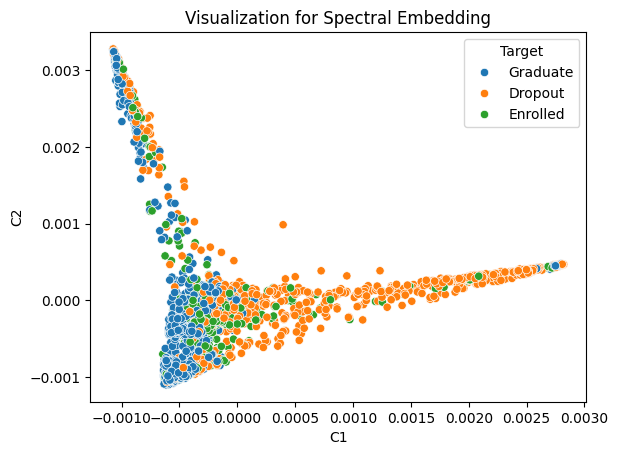

In [7]:
sns.scatterplot(df_se, x='C1', y='C2', hue='Target')
plt.title('Visualization for Spectral Embedding')

## t-SNE

In [8]:
ndlr_tsne = TSNE()
X_train_prep_2d_tsne = ndlr_tsne.fit_transform(X_train_prep)
df_tsne = pd.concat([pd.DataFrame(X_train_prep_2d_tsne, columns=['C1', 'C2']), pd.DataFrame(y_train, columns=['Target'])], axis=1)
df_tsne

,C1,C2,Target
0,2.555835,-17.028620,Graduate
1,8.129088,46.668964,Graduate
2,22.304337,-29.818676,Graduate
3,10.358740,-16.442705,Graduate
4,14.239414,59.374947,Dropout
...,...,...,...
3091,50.305370,35.685253,Graduate
3092,7.020790,-18.982626,Graduate
3093,28.577015,-29.958721,Graduate
3094,-21.229918,21.566235,Dropout


Text(0.5, 1.0, 'Visualization for t-SNE')

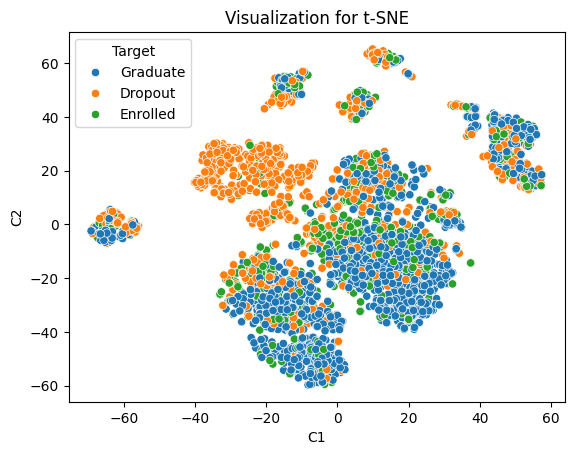

In [9]:
sns.scatterplot(df_tsne, x='C1', y='C2', hue='Target')
plt.title('Visualization for t-SNE')

## UMAP

In [10]:
ndlr_umap = UMAP()
X_train_prep_2d_umap = ndlr_umap.fit_transform(X_train_prep)
df_umap = pd.concat([pd.DataFrame(X_train_prep_2d_umap, columns=['C1', 'C2']), pd.DataFrame(y_train, columns=['Target'])], axis=1)
df_umap

,C1,C2,Target
0,-1.458633,-5.549011,Graduate
1,-1.702234,14.479128,Graduate
2,-3.499312,-5.950235,Graduate
3,-1.842414,-5.173535,Graduate
4,3.690190,14.455032,Dropout
...,...,...,...
3091,2.279493,9.925660,Graduate
3092,-1.234037,-5.532625,Graduate
3093,-3.420156,-5.757321,Graduate
3094,1.018391,0.048924,Dropout


Text(0.5, 1.0, 'Visualization for UMAP')

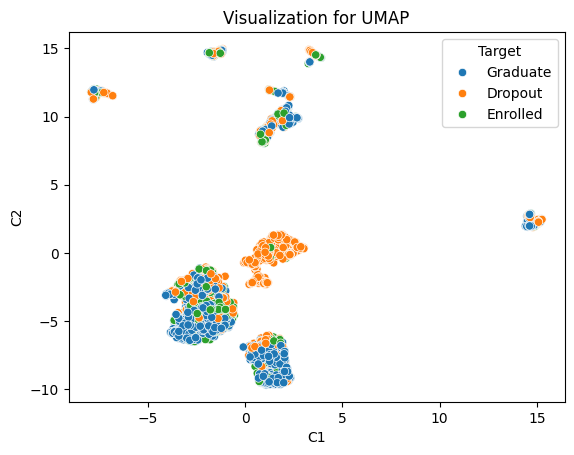

In [11]:
sns.scatterplot(df_umap, x='C1', y='C2', hue='Target')
plt.title('Visualization for UMAP')

# Classifier using 2 Components only

Function that first preprocesses features accordingly, then reduce all to only 2 dimensions before classification.

In [12]:
def random_search_results(X, y, model):

    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y.to_numpy().ravel(), # to avoid DataConversionWarning
        test_size=0.3,
        stratify=y,
        random_state=42
    )
    
    columntransfomer = ColumnTransformer(
        [
            ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist', min_frequency=.005), col_ohe),
            ('std', StandardScaler(), col_std_scale),
            ('pt', PowerTransformer(method='yeo-johnson'), col_pt_scale),
            ('qt', QuantileTransformer(output_distribution='uniform'), col_qt_scale)
        ], 
        remainder='passthrough'
    )

    X_train_prep = columntransfomer.fit_transform(X_train)
    X_test_prep = columntransfomer.transform(X_test)

    nldr = model    
    X_train_prep_2d = nldr.fit_transform(X_train_prep)
    X_test_prep_2d = nldr.fit_transform(X_test_prep)

    pipeline = Pipeline(
        [
            ('model', SVC())
        ]
    )

    param_distributions = {
        'model__C': stats.loguniform(1, 1000),
        'model__kernel': ['rbf'],
        'model__gamma': stats.loguniform(0.0001, 10)
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=100,
        scoring='accuracy',
        verbose=3,
        cv=cv,
        return_train_score=True
    )

    random_search.fit(X_train_prep_2d, y_train)

    print(f'best score: {random_search.best_score_}\n')
    print(f'best params: {random_search.best_params_}\n')
    print(classification_report(y_test, random_search.best_estimator_.predict(X_test_prep_2d)))
    ConfusionMatrixDisplay.from_estimator(random_search.best_estimator_, X_test_prep_2d, y_test)

    return random_search, X_test_prep_2d

## Laplacian Eigenmaps

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END model__C=7.75411386123831, model__gamma=0.01720940284881362, model__kernel=rbf;, score=(train=0.499, test=0.500) total time=   0.1s
[CV 2/3] END model__C=7.75411386123831, model__gamma=0.01720940284881362, model__kernel=rbf;, score=(train=0.500, test=0.499) total time=   0.1s
[CV 3/3] END model__C=7.75411386123831, model__gamma=0.01720940284881362, model__kernel=rbf;, score=(train=0.500, test=0.499) total time=   0.1s
[CV 1/3] END model__C=9.773451436936188, model__gamma=8.000168104218686, model__kernel=rbf;, score=(train=0.499, test=0.500) total time=   0.1s
[CV 2/3] END model__C=9.773451436936188, model__gamma=8.000168104218686, model__kernel=rbf;, score=(train=0.500, test=0.499) total time=   0.1s
[CV 3/3] END model__C=9.773451436936188, model__gamma=8.000168104218686, model__kernel=rbf;, score=(train=0.500, test=0.499) total time=   0.1s
[CV 1/3] END model__C=12.224785149866086, model__gamma=0.0007952773887

c:\Users\Deomary\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Deomary\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Deomary\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


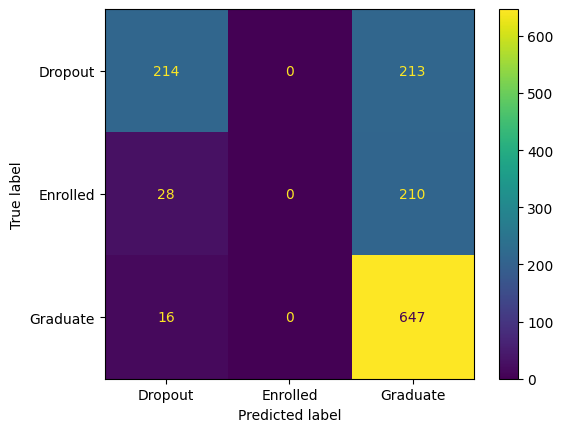

In [13]:
random_search_svc_se, X_test_prep_2d_se = random_search_results(X, y, SpectralEmbedding())

## t-SNE

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END model__C=336.5151241550981, model__gamma=0.35980469842187435, model__kernel=rbf;, score=(train=0.990, test=0.627) total time=   0.4s
[CV 2/3] END model__C=336.5151241550981, model__gamma=0.35980469842187435, model__kernel=rbf;, score=(train=0.987, test=0.608) total time=   0.3s
[CV 3/3] END model__C=336.5151241550981, model__gamma=0.35980469842187435, model__kernel=rbf;, score=(train=0.990, test=0.597) total time=   0.4s
[CV 1/3] END model__C=14.531853695665088, model__gamma=0.0008475922900921367, model__kernel=rbf;, score=(train=0.673, test=0.671) total time=   0.1s
[CV 2/3] END model__C=14.531853695665088, model__gamma=0.0008475922900921367, model__kernel=rbf;, score=(train=0.668, test=0.668) total time=   0.1s
[CV 3/3] END model__C=14.531853695665088, model__gamma=0.0008475922900921367, model__kernel=rbf;, score=(train=0.671, test=0.664) total time=   0.1s
[CV 1/3] END model__C=6.951149542832891, model__gamm

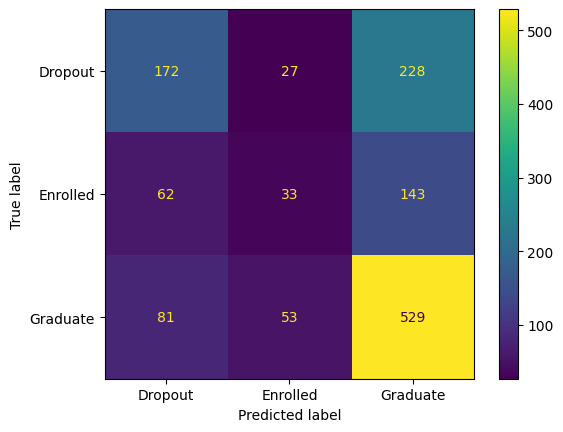

In [14]:
random_search_svc_tsne, X_test_prep_2d_tsne = random_search_results(X, y, TSNE())

## UMAP

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END model__C=111.49853354490168, model__gamma=0.40911283762477324, model__kernel=rbf;, score=(train=0.702, test=0.674) total time=   0.4s
[CV 2/3] END model__C=111.49853354490168, model__gamma=0.40911283762477324, model__kernel=rbf;, score=(train=0.700, test=0.670) total time=   0.4s
[CV 3/3] END model__C=111.49853354490168, model__gamma=0.40911283762477324, model__kernel=rbf;, score=(train=0.693, test=0.677) total time=   0.4s
[CV 1/3] END model__C=87.38838405083884, model__gamma=0.1531255944631882, model__kernel=rbf;, score=(train=0.689, test=0.682) total time=   0.3s
[CV 2/3] END model__C=87.38838405083884, model__gamma=0.1531255944631882, model__kernel=rbf;, score=(train=0.689, test=0.659) total time=   0.2s
[CV 3/3] END model__C=87.38838405083884, model__gamma=0.1531255944631882, model__kernel=rbf;, score=(train=0.683, test=0.668) total time=   0.2s
[CV 1/3] END model__C=375.17468469545656, model__gamma=0.0120

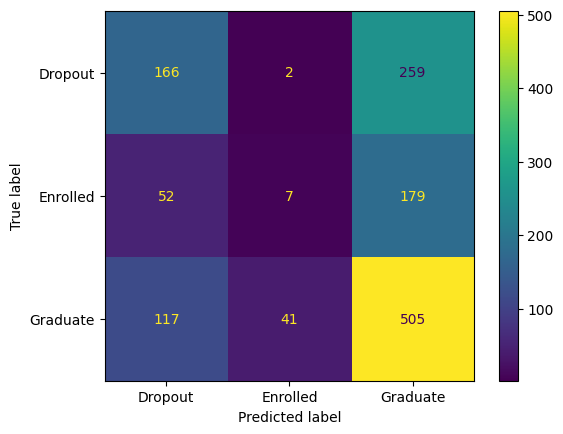

In [15]:
random_search_svc_umap, X_test_prep_2d_umap = random_search_results(X, y, UMAP())

# Classifier with Manifold Learning on Continuous Columns only

Function that first preprocesses features accordingly, then reduce only the continuous data to 2 dimensions (retaining the binary and categorical columns).

In [16]:
def random_search_results_2(X, y, model):

    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y.to_numpy().ravel(), # to avoid DataConversionWarning
        test_size=0.3,
        stratify=y,
        random_state=42
    )
    continuous_transformer = ColumnTransformer(
        [
            ('std', StandardScaler(), col_std_scale),
            ('pt', PowerTransformer(method='yeo-johnson'), col_pt_scale),
            ('qt', QuantileTransformer(output_distribution='uniform'), col_qt_scale),
        ]
    )
    continuous_X_train = continuous_transformer.fit_transform(X_train)
    continuous_X_test = continuous_transformer.transform(X_test)

    nldr = model
    nldr_X_train = nldr.fit_transform(continuous_X_train)
    nldr_X_test = nldr.fit_transform(continuous_X_test)

    ohe_transformer = ColumnTransformer(
        [
            ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist', min_frequency=.005), col_ohe)
        ],
        remainder='passthrough'
    )
    ohe_X_train = ohe_transformer.fit_transform(X_train)
    ohe_X_test = ohe_transformer.transform(X_test)

    all_X_train = np.c_[nldr_X_train, ohe_X_train]
    all_X_test = np.c_[nldr_X_test, ohe_X_test]

    pipeline = Pipeline(
        [
            ('model', SVC())
        ]
    )

    param_distributions = {
        'model__C': stats.loguniform(1, 1000),
        'model__kernel': ['rbf'],
        'model__gamma': stats.loguniform(0.0001, 10)
    }

    cv = StratifiedKFold(
        n_splits=3, 
        shuffle=True, 
        random_state=42
    )


    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=100,
        scoring='accuracy',
        verbose=3,
        cv=cv,
        return_train_score=True
    )

    random_search.fit(all_X_train, y_train)

    print(f'best score: {random_search.best_score_}\n')
    print(f'best params: {random_search.best_params_}\n')
    print(classification_report(y_test, random_search.best_estimator_.predict(all_X_test)))
    ConfusionMatrixDisplay.from_estimator(random_search.best_estimator_, all_X_test, y_test)

    return random_search, all_X_test

## Laplacian Eigenmaps

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END model__C=10.924547166333939, model__gamma=0.014873678575824601, model__kernel=rbf;, score=(train=1.000, test=0.676) total time=   0.4s
[CV 2/3] END model__C=10.924547166333939, model__gamma=0.014873678575824601, model__kernel=rbf;, score=(train=1.000, test=0.679) total time=   0.4s
[CV 3/3] END model__C=10.924547166333939, model__gamma=0.014873678575824601, model__kernel=rbf;, score=(train=1.000, test=0.666) total time=   0.4s
[CV 1/3] END model__C=50.05171370363907, model__gamma=0.00026826723890390625, model__kernel=rbf;, score=(train=0.812, test=0.778) total time=   0.2s
[CV 2/3] END model__C=50.05171370363907, model__gamma=0.00026826723890390625, model__kernel=rbf;, score=(train=0.812, test=0.761) total time=   0.2s
[CV 3/3] END model__C=50.05171370363907, model__gamma=0.00026826723890390625, model__kernel=rbf;, score=(train=0.823, test=0.767) total time=   0.2s
[CV 1/3] END model__C=4.96815672174043, model_

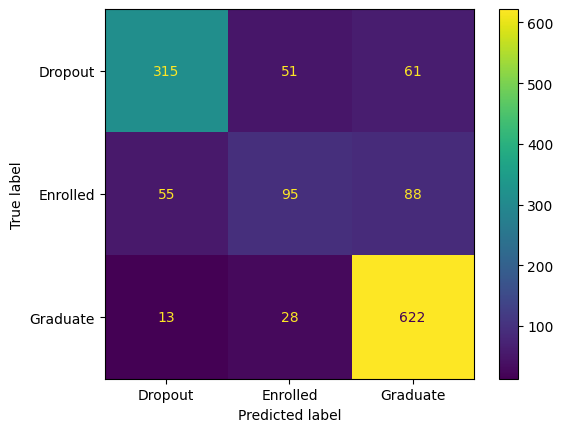

In [17]:
random_search_svc_se2, X_test_prep_2d_se2 = random_search_results_2(X, y, SpectralEmbedding())

## t-SNE

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END model__C=274.5561129880771, model__gamma=0.004729533578617402, model__kernel=rbf;, score=(train=1.000, test=0.675) total time=   0.4s
[CV 2/3] END model__C=274.5561129880771, model__gamma=0.004729533578617402, model__kernel=rbf;, score=(train=1.000, test=0.674) total time=   0.4s
[CV 3/3] END model__C=274.5561129880771, model__gamma=0.004729533578617402, model__kernel=rbf;, score=(train=1.000, test=0.648) total time=   0.4s
[CV 1/3] END model__C=392.5471759880385, model__gamma=0.005481245992018439, model__kernel=rbf;, score=(train=1.000, test=0.675) total time=   0.4s
[CV 2/3] END model__C=392.5471759880385, model__gamma=0.005481245992018439, model__kernel=rbf;, score=(train=1.000, test=0.670) total time=   0.4s
[CV 3/3] END model__C=392.5471759880385, model__gamma=0.005481245992018439, model__kernel=rbf;, score=(train=1.000, test=0.649) total time=   0.4s
[CV 1/3] END model__C=40.63842706813121, model__gamma=0

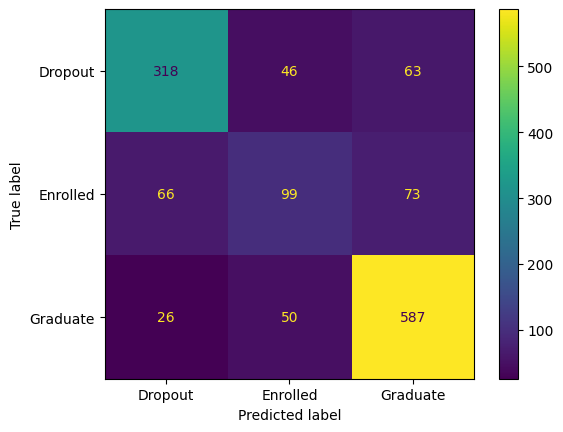

In [22]:
random_search_svc_tsne2, X_test_prep_2d_tsne2 = random_search_results_2(X, y, TSNE())

## UMAP

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END model__C=42.381251147606626, model__gamma=0.0019139629872573832, model__kernel=rbf;, score=(train=0.959, test=0.727) total time=   0.3s
[CV 2/3] END model__C=42.381251147606626, model__gamma=0.0019139629872573832, model__kernel=rbf;, score=(train=0.967, test=0.708) total time=   0.3s
[CV 3/3] END model__C=42.381251147606626, model__gamma=0.0019139629872573832, model__kernel=rbf;, score=(train=0.967, test=0.702) total time=   0.3s
[CV 1/3] END model__C=150.94302766789158, model__gamma=2.685482080064275, model__kernel=rbf;, score=(train=1.000, test=0.500) total time=   0.8s
[CV 2/3] END model__C=150.94302766789158, model__gamma=2.685482080064275, model__kernel=rbf;, score=(train=1.000, test=0.499) total time=   0.7s
[CV 3/3] END model__C=150.94302766789158, model__gamma=2.685482080064275, model__kernel=rbf;, score=(train=1.000, test=0.499) total time=   0.7s
[CV 1/3] END model__C=18.33279821500162, model__gamma=0

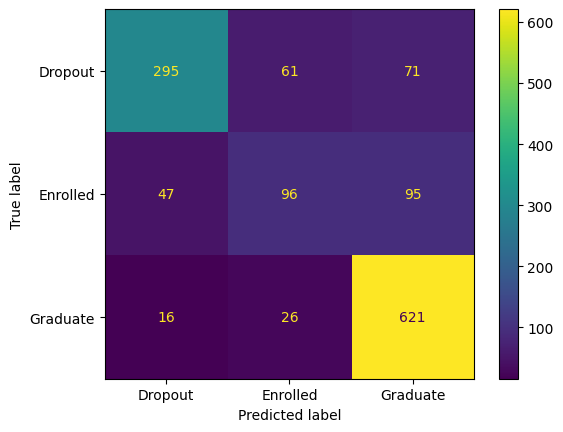

In [24]:
random_search_svc_umap2, X_test_prep_2d_umap2 = random_search_results_2(X, y, UMAP())

# Summary

In [25]:
def highlight_max(data, hl_index=False, color='green'):
    if hl_index:
        is_max = data.groupby(level=1).transform('max') == data
    else:
        is_max = data.max() == data
    return [f'background-color: {color}' if v else '' for v in is_max]

In [26]:
names = [
    'Laplacian Eigenmaps (reduce all)',
    't-SNE (reduce all)',
    'UMAP (reduce all)',
    'Laplacian Eigenmaps (reduce numerical only)',
    't-SNE (reduce numerical only)',
    'UMAP (reduce numerical only)',    
]

grid_results = [
    random_search_svc_se,
    random_search_svc_tsne,
    random_search_svc_umap,
    random_search_svc_se2,
    random_search_svc_tsne2,
    random_search_svc_umap2,
]

X_tests = [
    X_test_prep_2d_se,
    X_test_prep_2d_tsne,
    X_test_prep_2d_umap,
    X_test_prep_2d_se2,
    X_test_prep_2d_tsne2,
    X_test_prep_2d_umap2,
]

dfs = []

for name, result, test in zip(names, grid_results, X_tests):
    print(name)
    df = (
            pd.DataFrame(
                classification_report(
                    y_test,
                    result.best_estimator_.predict(test), 
                    output_dict=True
                )
            )
            .map(round, ndigits=4)
            .drop(index=['support'])
    )
    df.index = pd.MultiIndex.from_product([[name], df.index])

    dfs.append(df)

df_concat = pd.concat(dfs)
df_styled = df_concat.style.apply(
    highlight_max, 
    subset=pd.IndexSlice[:, ['Dropout', 'Enrolled', 'Graduate', 'accuracy', 'macro avg', 'weighted avg']],
    hl_index=True,
)
df_styled

Laplacian Eigenmaps (reduce all)
t-SNE (reduce all)


c:\Users\Deomary\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Deomary\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Deomary\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


UMAP (reduce all)
Laplacian Eigenmaps (reduce numerical only)
t-SNE (reduce numerical only)
UMAP (reduce numerical only)


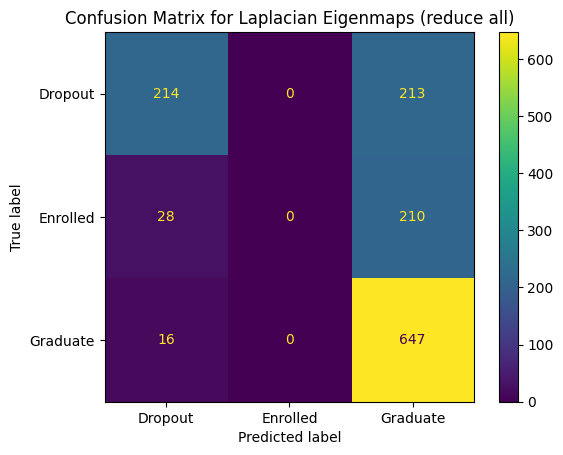

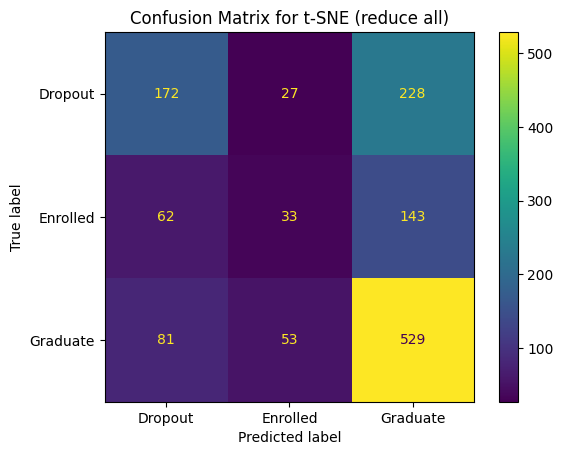

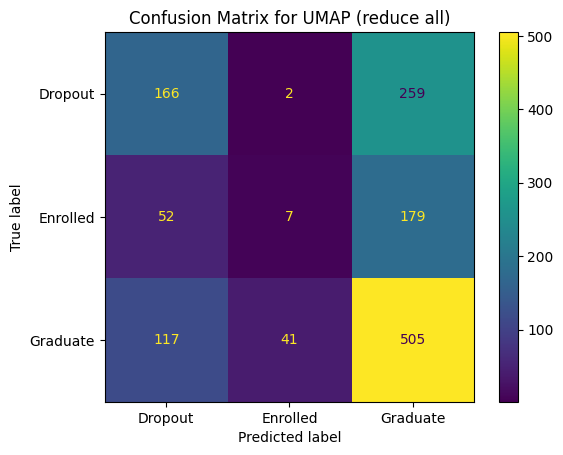

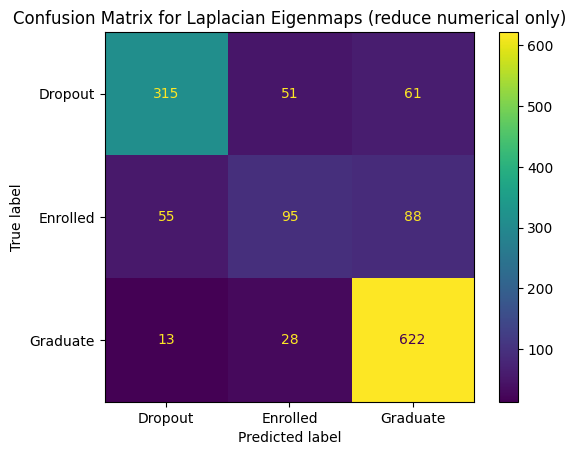

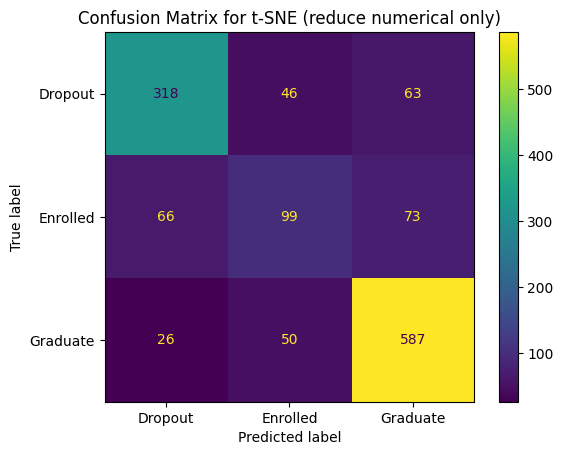

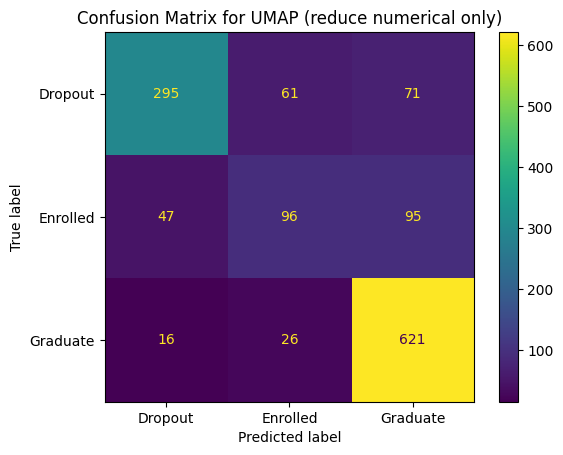

In [27]:
for name, result, test in zip(names, grid_results, X_tests):
    ConfusionMatrixDisplay.from_estimator(result.best_estimator_, test, y_test)
    plt.title(f'Confusion Matrix for {name}')

As observed, the classifications are helpful in visualizing the dataset in 2D and is able to group together partially the data according to Dropout, Enrolled, or Graduate, without even seeing the labels during the dimensionality reduction. However, the machine learning models perform poorly if it is only seeing 2 features during training (especially the Laplacian eigenmaps has predicted 0 Enrolled). But upon observing the models where it is seeing the the preprocessed features where only the continuous data dimension are reduced, the results are comparable to the previous exercises where no dimensionality reduction, PCA, or LDA were used.

In [28]:
score_dict = {}
for name, result, test in zip(names, grid_results, X_tests):
    score_dict[name] = [
        result.best_estimator_.score(
            test,
            y_test
        ),
        cohen_kappa_score(
            y_test, 
            result.best_estimator_.predict(test)
        )
    ]

score_df = pd.DataFrame(score_dict, index=['accuracy', 'kappa']).T.apply(round, ndigits=4)
score_df = score_df.style.apply(
    highlight_max
)
score_df

,accuracy,kappa
Laplacian Eigenmaps (reduce all),0.648300,0.343000
t-SNE (reduce all),0.552700,0.215500
UMAP (reduce all),0.510500,0.122300
Laplacian Eigenmaps (reduce numerical only),0.777100,0.624700
t-SNE (reduce numerical only),0.756000,0.595100
UMAP (reduce numerical only),0.762000,0.598600


Here, the accuracy for models which are partially dimensionally reduced shows comparable accuracy (is able to predict accurately 3/4 of the time) and ~0.6 kappa score.